# Matrix factorization for dressipi dataset tutorial

[Dressipi](https://dressipi.com/) is the UK's leading fashion discovery platform. It is a fashion recommendation engine that helps users discover new fashion items based on their preferences. 
In this notebook, we will use the dressipi dataset to build a baseline model using matrix factorization.

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product
from rec_baseline.algos import VanillaMF
from torch.utils.data import Dataset, DataLoader
from rec_baseline.common import get_device
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/collaborative-filtering-baseline-VTPPmAaj-py3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Getting data

We will use the dressipi dataset from [here](https://dressipi.com/downloads/recsys-datasets/).

In [2]:
session_df = pd.read_csv("../dataset/dressipi_recsys2022_dataset/train_sessions.csv")
purchase_df = pd.read_csv("../dataset/dressipi_recsys2022_dataset/train_purchases.csv")

session_df.head()
session_df.shape

purchase_df.head()
purchase_df.shape

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211


(4743820, 3)

,session_id,item_id,date
0,3,15085,2020-12-18 21:26:47.986
1,13,18626,2020-03-13 19:36:15.507
2,18,24911,2020-08-26 19:20:32.049
3,19,12534,2020-11-02 17:16:45.92
4,24,13226,2020-02-26 18:27:44.114


(1000000, 3)

The diagram below shows how the purchasing sessions were constructed from the full session and purchasing data. For full details, please see in [this](http://www.recsyschallenge.com/2022/dataset.html).

![](../images/dressipi_data_diagram.png)

As you can see, the data were constructed in a way of sequential recommendation. In order to use the data for matrix factorization, we need to reconstruct the data into a matrix form, like the one below.

![](../images/dressipi_matrix_form.png)

The matrix above is a session-item matrix. The rows are sessions and the columns are items. The values in the matrix are the indicator whether session `i` purchased item `j` or not.

With this approach, we ignore the order of the items in the purchasing sessions. 

## Modeling

In this section, we will show how to build a baseline model using matrix factorization. Naively, we can use the matrix above to build a matrix factorization model. However, this approach will not work well because the matrix is very sparse. So, we need to use a trick to make it works.

In [3]:
device = get_device()
seed = 100

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [4]:
sample_purchase_df = purchase_df.sample(n=1000, random_state=seed)
sample_purchase_df.head()
sample_purchase_df.shape

,session_id,item_id,date
617759,2742378,6795,2020-07-11 22:12:28.164
693227,3078823,20275,2020-09-24 06:31:38.484
906065,4023194,7267,2020-09-27 11:24:52.298
828507,3678659,2089,2020-10-27 14:38:28.312
869730,3862260,19933,2020-04-08 09:55:55.069


(1000, 3)

In [5]:
n_sessions = sample_purchase_df["session_id"].nunique()
n_items = sample_purchase_df["item_id"].nunique()

n_sessions, n_items

(1000, 896)

### Preprocessing

In [6]:
session2idx = {session: idx for idx, session in enumerate(sample_purchase_df.session_id.unique())}
idx2session = {idx: session for session, idx in session2idx.items()}

item2idx = {item: idx for idx, item in enumerate(sample_purchase_df.item_id.unique())}
idx2item = {idx: item for item, idx in item2idx.items()}

purchase_df_copy = sample_purchase_df.copy()
purchase_df_copy["session_id"] = purchase_df_copy["session_id"].apply(lambda x: session2idx[x])
purchase_df_copy["item_id"] = purchase_df_copy["item_id"].apply(lambda x: item2idx[x])

purchase_df_copy.head()

,session_id,item_id,date
617759,0,0,2020-07-11 22:12:28.164
693227,1,1,2020-09-24 06:31:38.484
906065,2,2,2020-09-27 11:24:52.298
828507,3,3,2020-10-27 14:38:28.312
869730,4,4,2020-04-08 09:55:55.069


Obviously, the dataset contains only purchased items. So, we need to add some negative samples to the dataset. By assuming that the items that we marked as negative samples are not purchased by the sessions.

In [7]:
purchase_df_copy["is_purchase"] = 1

# negative samples
negative_samples = []
for session in purchase_df_copy["session_id"].unique():
    negative_items = sample_purchase_df[~sample_purchase_df["item_id"].isin(purchase_df_copy[purchase_df_copy["session_id"] == session]["item_id"].unique())]["item_id"].unique()
    choices = np.array(list(product([session], negative_items)))
    rng = np.random.default_rng(seed + session)
    idx = rng.choice(len(choices), size=10, replace=False)
    negative_samples.extend(choices[idx])

negative_samples_df = pd.DataFrame(negative_samples, columns=["session_id", "item_id"])

negative_samples_df["is_purchase"] = 0

combined_df = pd.concat([purchase_df_copy, negative_samples_df], axis=0).reset_index(drop=True)
combined_df.head()
combined_df.tail()

,session_id,item_id,date,is_purchase
0,0,0,2020-07-11 22:12:28.164,1
1,1,1,2020-09-24 06:31:38.484,1
2,2,2,2020-09-27 11:24:52.298,1
3,3,3,2020-10-27 14:38:28.312,1
4,4,4,2020-04-08 09:55:55.069,1


,session_id,item_id,date,is_purchase
10995,999,10982,NaN,0
10996,999,25102,NaN,0
10997,999,13542,NaN,0
10998,999,24488,NaN,0
10999,999,13957,NaN,0


### Naive approach

#### Hyperparameter

In [8]:
N_EPOCH = 20
BATCH_SIZE = 1024
LEARNING_RATE = 3e-3
LATENT_DIM = 7

#### Creating a dataloader

In [9]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        session_id = self.df.iloc[idx].session_id
        item_id = self.df.iloc[idx].item_id
        rating = self.df.iloc[idx].is_purchase
        
        return session_id.astype("int"), item_id.astype("int"), rating.astype("float32")

In [10]:
# Train test split
train_df = combined_df.copy().sample(frac=0.8, random_state=seed)
test_df = combined_df.copy().drop(train_df.index)

# Create dataloader
train_loader = DataLoader(
    CustomDataset(train_df.copy()),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_loader = DataLoader(
    CustomDataset(test_df.copy()),
    batch_size=test_df.shape[0],
)

In [11]:
# Sample batch output
iter(train_loader).next()

[tensor([646, 268, 730,  ...,  80, 701, 399]),
 tensor([ 8130, 23038, 22567,  ..., 19514,   653, 26106]),
 tensor([0., 0., 0.,  ..., 0., 1., 0.])]

#### Defining the model

In [12]:
naive_model = VanillaMF(
    n_users=n_sessions, 
    n_items=n_items,
    latent_dim=LATENT_DIM
).to(device)

In [13]:
opt = torch.optim.Adam(naive_model.parameters(), lr=LEARNING_RATE)

In [14]:
loss_hist = []
eval_loss_hist = []

for epoch in range(0, N_EPOCH):
    for i, (session_id, item_ids, ratings) in enumerate(train_loader):
        session_id = session_id.to(device)
        item_ids = item_ids.to(device)
        ratings = ratings.to(device)
        
        # training
        _ = naive_model.train()
        opt.zero_grad()
        
        pred_scores = naive_model(session_id, item_ids)
        
        # using binary cross entropy loss
        # loss = torch.nn.functional.binary_cross_entropy_with_logits(pred_scores, ratings)
        
        # using mean squared error loss
        loss = VanillaMF.loss_fn(pred_scores, ratings)
        
        loss.backward()
        opt.step()
        
        # evaluation
        _ = naive_model.eval()
        
        with torch.no_grad():
            eval_loss = 0
            for j, (session_id, item_ids, ratings) in enumerate(test_loader):
                session_id = session_id.to(device)
                item_ids = item_ids.to(device)
                ratings = ratings.to(device)
                
                # using binary cross entropy loss
                # pred_scores = naive_model(session_id, item_ids)
                # pred = torch.sigmoid(pred_scores)
                # eval_loss += VanillaMF.loss_fn(pred, ratings)
                
                # using mean squared error loss
                pred_scores = naive_model(session_id, item_ids)
                eval_loss += VanillaMF.loss_fn(pred_scores, ratings)
                
            eval_loss /= len(test_loader)
        
        loss_hist.append(loss.item())
        eval_loss_hist.append(eval_loss.item())
        
    if epoch % 1 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item():.4f}, Eval Loss: {eval_loss.item():.4f}")

Epoch: 0, Loss: 0.9759, Eval Loss: 0.7216
Epoch: 1, Loss: 0.9787, Eval Loss: 0.7155
Epoch: 2, Loss: 0.5052, Eval Loss: 0.7101
Epoch: 3, Loss: 0.7537, Eval Loss: 0.7052
Epoch: 4, Loss: 0.9154, Eval Loss: 0.7007
Epoch: 5, Loss: 0.6596, Eval Loss: 0.6963
Epoch: 6, Loss: 0.6471, Eval Loss: 0.6924
Epoch: 7, Loss: 0.6466, Eval Loss: 0.6885
Epoch: 8, Loss: 0.6891, Eval Loss: 0.6852
Epoch: 9, Loss: 0.6022, Eval Loss: 0.6818
Epoch: 10, Loss: 0.4622, Eval Loss: 0.6788
Epoch: 11, Loss: 0.5763, Eval Loss: 0.6760
Epoch: 12, Loss: 0.4140, Eval Loss: 0.6732
Epoch: 13, Loss: 0.4531, Eval Loss: 0.6708
Epoch: 14, Loss: 0.3836, Eval Loss: 0.6684
Epoch: 15, Loss: 0.4845, Eval Loss: 0.6660
Epoch: 16, Loss: 0.3122, Eval Loss: 0.6641
Epoch: 17, Loss: 0.2666, Eval Loss: 0.6619
Epoch: 18, Loss: 0.3276, Eval Loss: 0.6602
Epoch: 19, Loss: 0.1775, Eval Loss: 0.6583


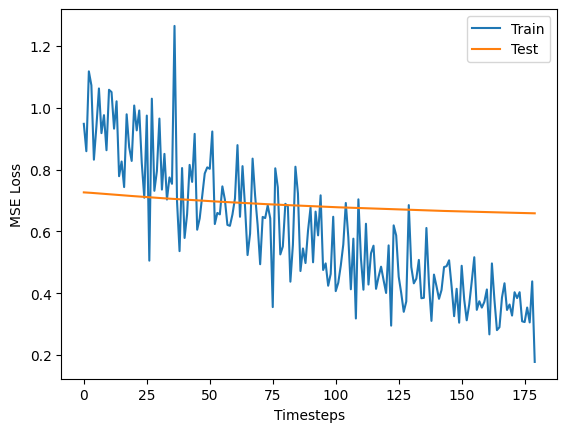

In [15]:
_ = plt.plot(loss_hist, label="Train")
_ = plt.plot(eval_loss_hist, label="Test")
_ = plt.xlabel("Timesteps")
_ = plt.ylabel("MSE Loss")
_ = plt.legend()